In [1]:
#https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost
#https://www.datasnips.com/5/tuning-xgboost-with-grid-search/
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
#https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names

import json
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from lime import lime_text
import gensim
import gensim.downloader as gensim_api


data = pd.read_csv('4coldata.csv')
data.drop(['score', 'length'], inplace = True, axis = 1)
data

,y,text
0,0,used app called melody two year app includes b...
1,0,felt reasonably tired bed time got bed closed ...
2,0,hear slept poorly next day luxury
3,0,whenever warm outside bird chirp outside windo...
4,0,mirtazapine remeron past year month ago began ...
...,...,...
18394,1,day many time incredible moodiness overwhelmin...
18395,1,hi everyone new poster sub trying see anyone e...
18396,1,hard time falling asleep exhausted cant switch...
18397,1,anyone else rly want sleep feel tired get anxi...


In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# split train dataset into train, validation and test sets

from sklearn.model_selection import train_test_split

X_train, temp_text, y_train, temp_labels = train_test_split(data['text'], data['y'], 
                                                                    random_state=20, 
                                                                    test_size=0.4, 
                                                                    stratify=data['y'])


X_val, X_test, y_val, y_test = train_test_split(temp_text, temp_labels, 
                                                                random_state=20, 
                                                              test_size=0.5, 
                                                              stratify=temp_labels)

In [4]:
'''def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, validate, test =train_validate_test_split(data)

X_train, y_train = train.drop(columns='y').copy(), train['y'].copy()
X_val, y_val = validate.drop(columns='y').copy(), validate['y'].copy()
X_test, y_test = test.drop(columns='y').copy(), test['y'].copy()

'''
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(11039,) (11039,) (3680,) (3680,) (3680,) (3680,)


In [5]:
print(y_test.value_counts())
print(y_val.value_counts())
print(y_train.value_counts())

0    1951
1    1729
Name: y, dtype: int64
0    1950
1    1730
Name: y, dtype: int64
0    5850
1    5189
Name: y, dtype: int64


In [6]:
##2#### LET'S DO IT ONE MORE TIME FOR BOW-COUNT n-grams

#max_features: top max_features ordered by term frequency across the corpus 
#max_df=1,

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer


#Count (classic BoW)
Cvectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10,  ngram_range=(1,3))

Cvectorizerv = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10,  ngram_range=(1,3))

Cvectorizert = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10, ngram_range=(1,3))

#use the vectorizer on the corpus to extract a vocabulary and create the feature matrix.  #max_features=500,

#corpus = data['text'].values.astype('U')
corpustrain = X_train.values.astype('U')
Cvectorizer.fit(corpustrain)
#Cvectorizer.fit(corpus)
X_trainC = Cvectorizer.transform(corpustrain)#.toarray() 
#dic_vocabulary = Cvectorizer.vocabulary_

corpusval = X_val.values.astype('U')
Cvectorizerv.fit(corpusval)
X_valC = Cvectorizerv.transform(corpusval)#.toarray() 
#dic_vocabularyv = Cvectorizerv.vocabulary_

corpustest = X_test.values.astype('U')
Cvectorizert.fit(corpustest)
X_testC = Cvectorizert.transform(corpustest)#.toarray() 
#dic_vocabularyt = Cvectorizert.vocabulary_


namedtrain=pd.DataFrame(X_trainC.toarray(),columns=Cvectorizer.get_feature_names())
namedval=pd.DataFrame(X_valC.toarray(),columns=Cvectorizerv.get_feature_names())
namedtest=pd.DataFrame(X_testC.toarray(),columns=Cvectorizert.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
#Let's see the common features for train, val, and test

print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = pd.concat([namedtrain, namedval], axis=0, join = 'inner')
three = pd.concat([trainval, namedtest], axis=0, join = 'inner')
print(three.shape)

comcol = three.columns
len(comcol)
namedtrain[comcol]

9902 3358 3471
(18399, 2787)


,ability,ability sleep,able,able fall,able fall asleep,able sleep,able sleep hour,able sleep night,able work,absolute,...,young,younger,youtube,zero,zero sleep,zoloft,zolpidem,zombie,zopiclone,zzzquil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = set(list(namedtrain.columns)).intersection(list(namedval.columns))
traintest = set(list(namedtrain.columns)).intersection(list(namedtest.columns))
valtest = set(list(namedval.columns)).intersection(list(namedtest.columns))
three = set(list(trainval)).intersection(list(namedtest.columns))
print(len(trainval), len(traintest),len(valtest),len(three))
#191 192 192 187

9902 3358 3471
3349 3458 2787 2787


In [9]:
print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = set(list(namedtrain.columns)).intersection(list(namedval.columns))
traintest = set(list(namedtrain.columns)).intersection(list(namedtest.columns))
valtest = set(list(namedval.columns)).intersection(list(namedtest.columns))
three = set(list(trainval)).intersection(list(namedtest.columns))
print(len(trainval), len(traintest),len(valtest),len(three))

9902 3358 3471
3349 3458 2787 2787


In [10]:
namedtrain[comcol]

,ability,ability sleep,able,able fall,able fall asleep,able sleep,able sleep hour,able sleep night,able work,absolute,...,young,younger,youtube,zero,zero sleep,zoloft,zolpidem,zombie,zopiclone,zzzquil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
## 3 ####. Tf-Idf (advanced variant of BoW)

#vectorizer = feature_extraction.text.TfidfVectorizer(max_features=200, ngram_range=(1,3))

vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english', min_df = 10, ngram_range=(1,3))
vectorizerv = feature_extraction.text.TfidfVectorizer(stop_words = 'english',min_df = 10, ngram_range=(1,3))
vectorizert = feature_extraction.text.TfidfVectorizer(stop_words = 'english', min_df = 10, ngram_range=(1,3))
#10000

#use the TF-IDF vectorizer on the corpus to extract a vocabulary and create the 
#feature matrix.

vectorizer.fit(corpustrain)
X_traintfidf= vectorizer.transform(corpustrain)#.toarray() 
tfidftrain = pd.DataFrame(X_traintfidf.todense())

vectorizerv.fit(corpusval)
X_valtfidf= vectorizerv.transform(corpusval)#.toarray() 
tfidfval = pd.DataFrame(X_valtfidf.todense())

vectorizert.fit(corpustest)
X_testtfidf= vectorizert.fit_transform(corpustest)#.toarray() 
tfidftest = pd.DataFrame(X_testtfidf.todense())

tfidftrain=pd.DataFrame(X_traintfidf.toarray(),columns=vectorizer.get_feature_names())
tfidfval=pd.DataFrame(X_valtfidf.toarray(),columns=vectorizerv.get_feature_names())
tfidftest=pd.DataFrame(X_testtfidf.toarray(),columns=vectorizert.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
namedtrain[comcol].shape

(11039, 2787)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


 Accuracy: 0.5641304347826087
Precision: 0.5793450881612091
 Recall: 0.2658959537572254
 F1: 0.3645007923930269


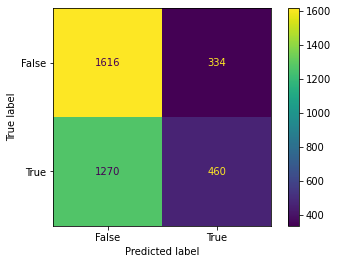

'Accuracy: 0.5792334873606958\nPrecision: 0.5676470588235294\n Recall: 0.34341637010676157\n F1: 0.4279379157427938\n all 2762 features '

In [12]:
### For n-gram BoW features  #with x common features for all three sets

from sklearn import metrics

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
   colsample_bytree= 0.75, learning_rate = 0.1, max_depth =6, 
                      min_child_weight = 1, subsample = 1)

# all {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1}

model.fit(namedtrain[comcol],y_train) 
predicted = model.predict(namedval[comcol])  #predict on validation set :)

print(" Accuracy:",metrics.accuracy_score(y_val, predicted))
print("Precision:",metrics.precision_score(y_val, predicted))
print(" Recall:",metrics.recall_score(y_val, predicted))
print(" F1:",metrics.f1_score(y_val, predicted))

confusion_matrix = metrics.confusion_matrix(y_val, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


'''Accuracy: 0.5659146507203044
Precision: 0.537052456286428
 Recall: 0.38256227758007116
 F1: 0.44683062002078283
 
Accuracy: 0.5502717391304348
Precision: 0.5323554788610871
 Recall: 0.35664739884393065
 F1: 0.4271374177916234
 
 200 feature'''

'''Accuracy: 0.5659146507203044
Precision: 0.5361494719740049
 Recall: 0.3914590747330961
 F1: 0.4525197120329106
 
Accuracy: 0.5548913043478261
Precision: 0.54
 Recall: 0.35895953757225435
 F1: 0.43125
 
 500 feature'''

'''Accuracy: 0.5792334873606958
Precision: 0.5676470588235294
 Recall: 0.34341637010676157
 F1: 0.4279379157427938
 all 2762 features 
 
 
 Accuracy: 0.5641304347826087
Precision: 0.5793450881612091
 Recall: 0.2658959537572254
 F1: 0.3645007923930269
 all 2787
 '''

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


 Accuracy: 0.5453804347826087
Precision: 0.5224232887490166
 Recall: 0.3838150289017341
 F1: 0.4425191602799067


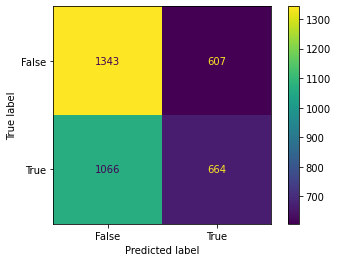

' Accuracy: 0.5483695652173913\nPrecision: 0.5277777777777778\n Recall: 0.37341040462427744\n F1: 0.43737305348679756\n \n tfidf 500\n '

In [19]:
##TF-IDF features 

from sklearn.svm import SVC, LinearSVC
from sklearn import metrics


model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
   colsample_bytree= 1, learning_rate = 0.1, max_depth =6, 
                      min_child_weight = 5, subsample = 0.75)

#tfidf 200 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.75}
#tfidf 500 'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.75}                    
                    
model.fit(tfidftrain[comcol],y_train) 
predicted = model.predict(tfidfval[comcol])  #predict on validation set :)

print(" Accuracy:",metrics.accuracy_score(y_val, predicted))
print("Precision:",metrics.precision_score(y_val, predicted))
print(" Recall:",metrics.recall_score(y_val, predicted))
print(" F1:",metrics.f1_score(y_val, predicted))

confusion_matrix = metrics.confusion_matrix(y_val, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

'''Accuracy: 0.5486413043478261
Precision: 0.5271013354281225
 Recall: 0.3878612716763006
 F1: 0.44688644688644685

 200- tfidf
 '''

''' Accuracy: 0.5483695652173913
Precision: 0.5277777777777778
 Recall: 0.37341040462427744
 F1: 0.43737305348679756
 
 tfidf 500
 '''

In [14]:
# combine train and validate sets for shared features

print(namedtrain.shape, namedval.shape)
X_train = pd.concat([namedtrain[comcol], namedval[comcol]], axis=0, join = 'inner')
print(X_train.shape)
X_traintfidf = pd.concat([tfidftrain[comcol], tfidfval[comcol]], axis=0, join = 'inner')
#X_train.columns = [''] * len(X_train.columns)
Y_train = pd.concat([y_train, y_val], axis=0)
print(Y_train.shape, y_train.shape, y_val.shape)
X_train

(11039, 9902) (3680, 3358)
(14719, 2787)


NameError: name 'tfidftrain' is not defined

In [19]:
'''clf = model.get_booster()
print(len(clf.feature_names))

for thresh in thresholds:
 # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True, feature_names_in_ = clf.feature_names)
    select_X_train = selection.transform(namedtrain[comcol])
    '''

'clf = model.get_booster()\nprint(len(clf.feature_names))\n\nfor thresh in thresholds:\n # select features using threshold\n    selection = SelectFromModel(model, threshold=thresh, prefit=True, feature_names_in_ = clf.feature_names)\n    select_X_train = selection.transform(namedtrain[comcol])\n    '

In [20]:
'''# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
 # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(namedtrain[comcol])
 # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_val)
 # eval model
    select_X_test = selection.transform(namedval[comcol])
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_val, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))'''

'# Fit model using each importance as a threshold\nthresholds = sort(model.feature_importances_)\nfor thresh in thresholds:\n # select features using threshold\n    selection = SelectFromModel(model, threshold=thresh, prefit=True)\n    select_X_train = selection.transform(namedtrain[comcol])\n # train model\n    selection_model = XGBClassifier()\n    selection_model.fit(select_X_train, y_val)\n # eval model\n    select_X_test = selection.transform(namedval[comcol])\n    predictions = selection_model.predict(select_X_test)\n    accuracy = accuracy_score(y_val, predictions)\n    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))'

In [13]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# create a dictionary containing the hyperparameters to tune and the range of values to try

PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
                "min_child_weight":[1, 5],
                "learning_rate":[0.1, 0.01]}


# create a validation set which will be used for early stopping
#eval_set = [(namedval[comcol], y_val)]
eval_set = [(tfidfval[comcol], y_val)]


# initialise an XGBoost classifier, set the number of estimators, evaluation metric & 
#early stopping rounds
estimator = xgb.XGBClassifier(n_estimators=100, 
                              n_jobs=-1, 
                              eval_metric='logloss',
                                early_stopping_rounds=10)

# initialise GridSearchCV model by passing the XGB classifier we initialised in the last 
#step along with the dictionary of parameters and values to try. We also set the number of 
#folds to validate over along with the scoring metric to use

model = GridSearchCV(estimator=estimator,
                   param_grid=PARAMETERS,
                      cv=5,
                      scoring="neg_log_loss")

# fit model
#model.fit(namedtrain[comcol], y_train, eval_set=eval_set, verbose=0)
model.fit(tfidftrain[comcol], y_train, eval_set=eval_set, verbose=0)


# print out the best hyperparameters
print(model.best_params_)


{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 1}


In [17]:
# combine train and validate sets for shared features

print(namedtrain.shape, namedval.shape)
X_train = pd.concat([namedtrain[comcol], namedval[comcol]], axis=0, join = 'inner')
print(X_train.shape)
#X_train.columns = [''] * len(X_train.columns)
Y_train = pd.concat([y_train, y_val], axis=0)
print(Y_train.shape, y_train.shape, y_val.shape)
X_train

(11039, 9902) (3680, 3358)
(14719, 2787)
(14719,) (11039,) (3680,)


,ability,ability sleep,able,able fall,able fall asleep,able sleep,able sleep hour,able sleep night,able work,absolute,...,young,younger,youtube,zero,zero sleep,zoloft,zolpidem,zombie,zopiclone,zzzquil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3677,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_test = namedtest[comcol]
#X_test.columns = [''] * len(namedtest[comcol].columns)
X_test
X_testtfidf = tfidftest[comcol]
X_testtfidf

NameError: name 'tfidftest' is not defined

[19:47:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_weigh" } are not used.

 Accuracy: 0.5584239130434783
Precision: 0.5670103092783505
 Recall: 0.25448235974551764
 F1: 0.3512974051896207


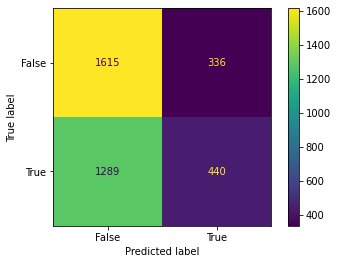

'Accuracy: 0.5569138820972562\nPrecision: 0.5633971291866029\n Recall: 0.2711571675302245\n F1: 0.36610959968907886\n All 2762 features\n '

In [20]:
from sklearn import metrics

model2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
                       colsample_bytree= 0.75, learning_rate= 0.1, 
                       max_depth= 6, min_child_weigh= 1, subsample= 1)

model2.fit(X_train,Y_train) 
# for 200 {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.75}
#for 500 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.75}
#for full {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1}
#all {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1}

predicted = model2.predict(X_test)  #predict on test set :)

print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))
print(" F1:",metrics.f1_score(y_test, predicted))


confusion_matrix = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

''' Accuracy: 0.5340939961966857
Precision: 0.5155807365439093
 Recall: 0.2095567069660334
 F1: 0.2979942693409742
 
Accuracy: 0.5521739130434783
Precision: 0.5324259407526021
 Recall: 0.38461538461538464
 F1: 0.4466084620550705
 
 200 features'''


'''Accuracy: 0.5354523227383863
Precision: 0.5178335535006605
 Recall: 0.22567645365572828
 F1: 0.3143544506816359
 
 Accuracy: 0.5605978260869565
Precision: 0.5438184663536776
 Recall: 0.40196645459803354
 F1: 0.46225473894246755
 
 500 features
 '''

'''Accuracy: 0.5569138820972562
Precision: 0.5633971291866029
 Recall: 0.2711571675302245
 F1: 0.36610959968907886
 All 2762 features
 
 Accuracy: 0.5584239130434783
Precision: 0.5670103092783505
 Recall: 0.25448235974551764
 F1: 0.3512974051896207
 
 All 2787
 '''

In [22]:
namedtest[comcol].shape

(3680, 2787)

In [23]:
X_testtfidf 

,able,able fall,able fall asleep,able sleep,absolutely,actually,advice,afraid,ago,aid,...,worried,worry,worse,worst,wrong,xanax,year,year ago,year old,yesterday
0,0.114839,0.000000,0.000000,0.000000,0.0,0.136241,0.0,0.0,0.000000,0.000000,...,0.174887,0.000000,0.0,0.0,0.0,0.0,0.210491,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.083031,0.0,0.0,0.000000,0.105993,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.161066,0.000000,0.000000,0.196342,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.292950,0.000000,0.000000,0.357111,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.477164,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3676,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.095243,0.0,0.0,0.0
3677,0.000000,0.000000,0.000000,0.000000,0.0,0.154505,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.119355,0.0,0.0,0.0
3678,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.312434,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[18:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_weigh" } are not used.

 Accuracy: 0.5494565217391304
Precision: 0.5272867025365103
 Recall: 0.3967611336032389
 F1: 0.4528052805280528


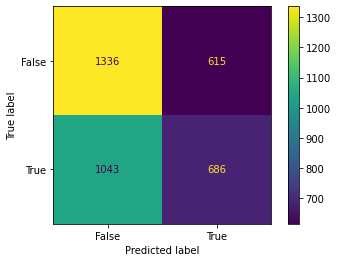

'Accuracy: 0.5494565217391304\nPrecision: 0.5272867025365103\n Recall: 0.3967611336032389\n F1: 0.4528052805280528\n 500 tfidf\n '

In [24]:
## TF-IDF feature


model2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', 
                       colsample_bytree= 0.75, learning_rate= 0.1, 
                       max_depth= 6, min_child_weigh= 5, subsample= 0.75)


model2.fit(X_traintfidf,Y_train) 


predicted = model2.predict(tfidftest[comcol])  #predict on test set :)

print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))
print(" F1:",metrics.f1_score(y_test, predicted))


confusion_matrix = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


'''Accuracy: 0.5467391304347826
Precision: 0.5234795996920708
 Recall: 0.3932909196067091
 F1: 0.4491413474240423
 200 tfidf
 '''


'''Accuracy: 0.5494565217391304
Precision: 0.5272867025365103
 Recall: 0.3967611336032389
 F1: 0.4528052805280528
 500 tfidf
 '''

In [25]:
X_train.shape

(14719, 453)

<AxesSubplot: >

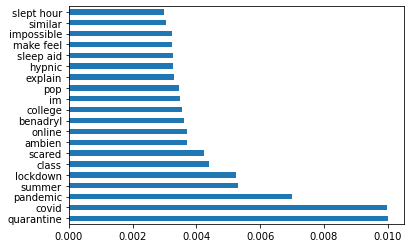

In [99]:
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh') #all 2762

<AxesSubplot: >

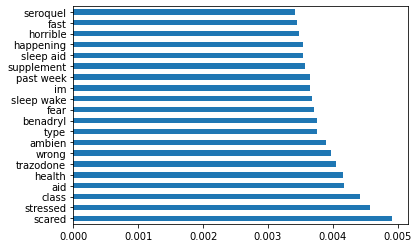

In [87]:
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh') #500

<AxesSubplot: >

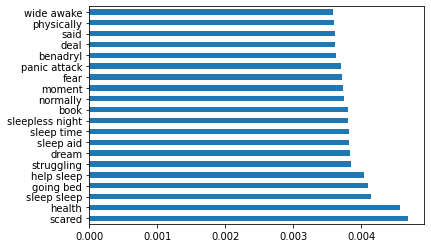

In [17]:
##2
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh') #500

<AxesSubplot: >

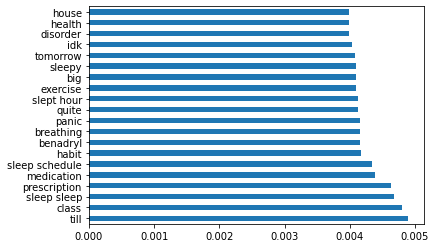

In [23]:
#TF IDF 

feat_importances = pd.Series(model2.feature_importances_, index=X_traintfidf.columns)
feat_importances.nlargest(20).plot(kind='barh') #500

<AxesSubplot: >

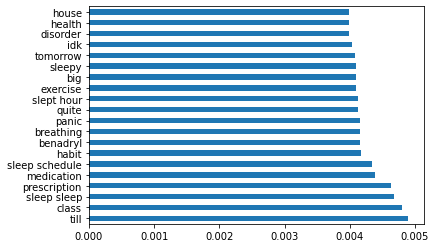

In [26]:
###2
#TF IDF 

feat_importances = pd.Series(model2.feature_importances_, index=X_traintfidf.columns)
feat_importances.nlargest(20).plot(kind='barh') #500

<AxesSubplot: >

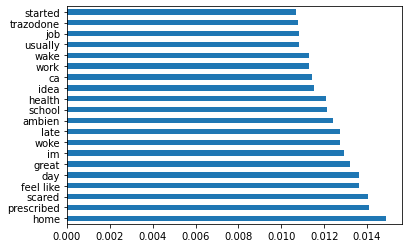

In [72]:
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh') #200

<AxesSubplot: >

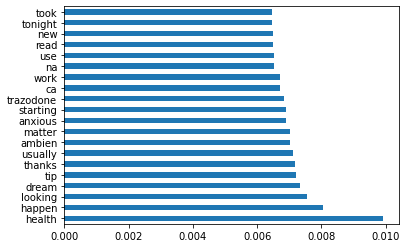

In [18]:
##2
feat_importances = pd.Series(model2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh') #200

<AxesSubplot: >

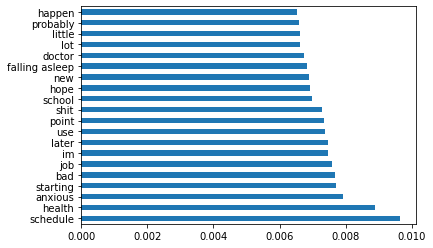

In [21]:
#TF IDF 200

feat_importances = pd.Series(model2.feature_importances_, index=X_traintfidf.columns)
feat_importances.nlargest(20).plot(kind='barh') #200

<AxesSubplot: >

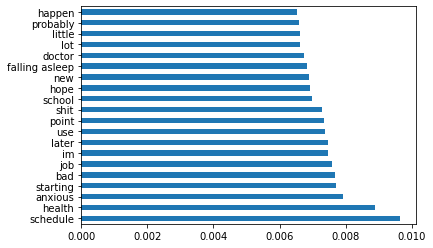

In [27]:
#2
#TF IDF 200

feat_importances = pd.Series(model2.feature_importances_, index=X_traintfidf.columns)
feat_importances.nlargest(20).plot(kind='barh') #200

In [ ]:

feat_importances = pd.Series(model2.feature_importances_, index=X_traintfidf.columns)
feat_importances.nlargest(20).plot(kind='barh') #200